In [1]:
%pip install datasets torchsummary

/bin/bash: /opt/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torchvision import models, transforms
from torchvision import transforms
from torchvision import models
#from datasets import load_dataset
from tqdm import tqdm
import torchvision.models as models
# from torchvision.datasets import ImageNet
from torchvision.datasets import ImageFolder
# from fastai.vision.all import *
# import matplotlib.pyplot as plt
#from fastai.vision.augment import Resize
from torch.utils.data import DataLoader
import numpy as np

In [3]:
path = 'imagenette2-160/'

In [4]:
# Define ImageNet normalization statistics

# Create common transformations for both training and validation
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply transformations directly to datasets
train_dataset = ImageFolder(root=path + '/train', transform=common_transforms)
val_dataset = ImageFolder(root=path + '/val', transform=common_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 8, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers = 8, pin_memory = True)

/net/dali/home/mscbio/gak147/.conda/envs/torch_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
for images, labels in train_loader:
    shape  = images.size()
    print(images.size())  # This will give you the size of the images batch
    break  # Exit after the first batch

torch.Size([64, 3, 224, 224])


In [6]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
num_classes = len(train_dataset.classes)
print(num_classes)

10


In [8]:
# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # torch.autograd.set_detect_anomaly(True)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradients for faster inference
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predictions

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

In [9]:
#figure out index of last fully connected layer
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Running the baseline

In [10]:
### ORIGINAL - NO CHANGES BESIDES LAST LAYER

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# model.fc = nn.Linear(model.fc.in_features, num_classes)

# for param in model.fc.parameters():
#   param.requires_grad = True

# Modify the final fully connected layer (classifier) to have 10 output classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Assuming the original last layer is at index 6

# Unfreeze the last fully connected layer (only the new last layer will be trained)
for param in model.classifier[6].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
# Set the device (either 'cuda' for GPU or 'cpu' for CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device
model = model.to(device)

In [12]:
# Training loop
num_epochs = 10
train_losses = np.zeros(num_epochs)
val_accuracies = np.zeros(num_epochs)
for epoch in np.arange(num_epochs):
    train_losses[epoch] = train(model, train_loader, criterion, optimizer, device)
    val_accuracies[epoch] = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[epoch]:.4f}, Val Accuracy: {val_accuracies[epoch]:.4f}")

100%|██████████| 62/62 [00:09<00:00,  6.49it/s]


Epoch 1, Train Loss: 0.3536, Val Accuracy: 0.9332


100%|██████████| 62/62 [00:08<00:00,  6.90it/s]


Epoch 2, Train Loss: 0.1949, Val Accuracy: 0.9386


100%|██████████| 62/62 [00:09<00:00,  6.85it/s]


Epoch 3, Train Loss: 0.1647, Val Accuracy: 0.9434


100%|██████████| 62/62 [00:09<00:00,  6.83it/s]


Epoch 4, Train Loss: 0.1503, Val Accuracy: 0.9516


100%|██████████| 62/62 [00:09<00:00,  6.72it/s]


Epoch 5, Train Loss: 0.1374, Val Accuracy: 0.9516


100%|██████████| 62/62 [00:09<00:00,  6.57it/s]


Epoch 6, Train Loss: 0.1298, Val Accuracy: 0.9473


100%|██████████| 62/62 [00:08<00:00,  7.16it/s]


Epoch 7, Train Loss: 0.1274, Val Accuracy: 0.9457


100%|██████████| 62/62 [00:09<00:00,  6.63it/s]


Epoch 8, Train Loss: 0.1205, Val Accuracy: 0.9521


100%|██████████| 62/62 [00:09<00:00,  6.64it/s]


Epoch 9, Train Loss: 0.1112, Val Accuracy: 0.9470


100%|██████████| 62/62 [00:09<00:00,  6.81it/s]

Epoch 10, Train Loss: 0.1133, Val Accuracy: 0.9470


Replacing the last layer

In [13]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model2 = model

# Freeze all parameters first
for param in model2.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model2.features[28] = nn.Linear(14,14)

model2.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model2.classifier[6].parameters():
  param.requires_grad = True

for param in model2.features[28].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [15]:
model2.to(device)

summary(model2, (3, 224, 224))
model2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
num_epochs = 10
train_loss_last = np.zeros(num_epochs)
val_accuracy_last = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_last[epoch] = train(model2, train_loader, criterion, optimizer, device)
    val_accuracy_last[epoch] = evaluate(model2, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_last[epoch]:.4f}, Val Accuracy: {val_accuracy_last[epoch]:.4f}")

100%|██████████| 62/62 [00:09<00:00,  6.72it/s]


Epoch 1, Train Loss: 1.2004, Val Accuracy: 0.8359


100%|██████████| 62/62 [00:09<00:00,  6.74it/s]


Epoch 2, Train Loss: 0.5662, Val Accuracy: 0.8647


100%|██████████| 62/62 [00:09<00:00,  6.65it/s]


Epoch 3, Train Loss: 0.4885, Val Accuracy: 0.8808


100%|██████████| 62/62 [00:09<00:00,  6.57it/s]


Epoch 4, Train Loss: 0.4494, Val Accuracy: 0.8790


100%|██████████| 62/62 [00:09<00:00,  6.78it/s]


Epoch 5, Train Loss: 0.4311, Val Accuracy: 0.8833


100%|██████████| 62/62 [00:09<00:00,  6.68it/s]


Epoch 6, Train Loss: 0.4040, Val Accuracy: 0.8882


100%|██████████| 62/62 [00:09<00:00,  6.54it/s]


Epoch 7, Train Loss: 0.4034, Val Accuracy: 0.8859


100%|██████████| 62/62 [00:09<00:00,  6.60it/s]


Epoch 8, Train Loss: 0.3961, Val Accuracy: 0.8907


100%|██████████| 62/62 [00:09<00:00,  6.76it/s]


Epoch 9, Train Loss: 0.3711, Val Accuracy: 0.8856


100%|██████████| 62/62 [00:09<00:00,  6.57it/s]

Epoch 10, Train Loss: 0.3746, Val Accuracy: 0.8920


Replacing first layer

In [17]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model3 = model

# Freeze all parameters first
for param in model3.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model3.features[2] = nn.Linear(224,224)

model3.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model3.classifier[6].parameters():
  param.requires_grad = True

for param in model3.features[2].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [19]:
model3.to(device)

summary(model3, (3, 224, 224))
model3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Linear-3         [-1, 64, 224, 224]          50,400
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [20]:
num_epochs = 10
train_loss_first = np.zeros(num_epochs)
val_accuracy_first = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_first[epoch] = train(model3, train_loader, criterion, optimizer, device)
    val_accuracy_first[epoch] = evaluate(model3, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_first[epoch]:.4f}, Val Accuracy: {val_accuracy_first[epoch]:.4f}")

100%|██████████| 62/62 [00:09<00:00,  6.62it/s]


Epoch 1, Train Loss: 1.9959, Val Accuracy: 0.3524


100%|██████████| 62/62 [00:09<00:00,  6.89it/s]


Epoch 2, Train Loss: 1.8329, Val Accuracy: 0.3682


100%|██████████| 62/62 [00:09<00:00,  6.71it/s]


Epoch 3, Train Loss: 1.7530, Val Accuracy: 0.4099


100%|██████████| 62/62 [00:08<00:00,  7.05it/s]


Epoch 4, Train Loss: 1.7010, Val Accuracy: 0.4382


100%|██████████| 62/62 [00:09<00:00,  6.72it/s]


Epoch 5, Train Loss: 1.6565, Val Accuracy: 0.4515


100%|██████████| 62/62 [00:09<00:00,  6.82it/s]


Epoch 6, Train Loss: 1.6429, Val Accuracy: 0.4431


100%|██████████| 62/62 [00:09<00:00,  6.75it/s]


Epoch 7, Train Loss: 1.6153, Val Accuracy: 0.4586


100%|██████████| 62/62 [00:08<00:00,  6.99it/s]


Epoch 8, Train Loss: 1.6042, Val Accuracy: 0.4489


100%|██████████| 62/62 [00:09<00:00,  6.85it/s]


Epoch 9, Train Loss: 1.5866, Val Accuracy: 0.4566


100%|██████████| 62/62 [00:09<00:00,  6.89it/s]

Epoch 10, Train Loss: 1.5883, Val Accuracy: 0.4668


Replacing middle layer

In [21]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model4 = model

# Freeze all parameters first
for param in model4.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model4.features[14] = nn.Linear(56,56)

model4.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model4.classifier[6].parameters():
  param.requires_grad = True

for param in model4.features[14].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model4.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
model4.to(device)

summary(model4, (3, 224, 224))
model4

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Linear(in_features=56, out_features=56, bias=True)
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [24]:
num_epochs = 10
train_loss_middle = np.zeros(num_epochs)
val_accuracy_middle = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_middle[epoch] = train(model4, train_loader, criterion, optimizer, device)
    val_accuracy_middle[epoch] = evaluate(model4, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_middle[epoch]:.4f}, Val Accuracy: {val_accuracy_middle[epoch]:.4f}")

100%|██████████| 62/62 [00:08<00:00,  6.96it/s]


Epoch 1, Train Loss: 1.8775, Val Accuracy: 0.4382


100%|██████████| 62/62 [00:08<00:00,  6.90it/s]


Epoch 2, Train Loss: 1.6166, Val Accuracy: 0.4581


100%|██████████| 62/62 [00:09<00:00,  6.71it/s]


Epoch 3, Train Loss: 1.5415, Val Accuracy: 0.5055


100%|██████████| 62/62 [00:08<00:00,  7.02it/s]


Epoch 4, Train Loss: 1.5002, Val Accuracy: 0.5180


100%|██████████| 62/62 [00:08<00:00,  6.97it/s]


Epoch 5, Train Loss: 1.4640, Val Accuracy: 0.5162


100%|██████████| 62/62 [00:08<00:00,  6.94it/s]


Epoch 6, Train Loss: 1.4377, Val Accuracy: 0.5185


100%|██████████| 62/62 [00:08<00:00,  6.97it/s]


Epoch 7, Train Loss: 1.4150, Val Accuracy: 0.5358


100%|██████████| 62/62 [00:08<00:00,  7.12it/s]


Epoch 8, Train Loss: 1.3972, Val Accuracy: 0.5264


100%|██████████| 62/62 [00:08<00:00,  6.97it/s]


Epoch 9, Train Loss: 1.3901, Val Accuracy: 0.5389


100%|██████████| 62/62 [00:09<00:00,  6.88it/s]

Epoch 10, Train Loss: 1.3583, Val Accuracy: 0.5488


First and middle layers replaced

In [25]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model5 = model

# Freeze all parameters first
for param in model5.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model5.features[2] = nn.Linear(224,224)
model5.features[14] = nn.Linear(56,56)

model5.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model5.classifier[6].parameters():
  param.requires_grad = True

for param in model5.features[14].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model5.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
model5.to(device)

summary(model5, (3, 224, 224))
model5

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Linear-3         [-1, 64, 224, 224]          50,400
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Linear(in_features=56, out_features=56, bias=True)
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): C

In [28]:
num_epochs = 10
train_loss_first_middle = np.zeros(num_epochs)
val_accuracy_first_middle = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_first_middle[epoch] = train(model5, train_loader, criterion, optimizer, device)
    val_accuracy_first_middle[epoch] = evaluate(model5, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_first_middle[epoch]:.4f}, Val Accuracy: {val_accuracy_first_middle[epoch]:.4f}")

100%|██████████| 62/62 [00:08<00:00,  6.90it/s]


Epoch 1, Train Loss: 2.0722, Val Accuracy: 0.3411


100%|██████████| 62/62 [00:09<00:00,  6.80it/s]


Epoch 2, Train Loss: 1.8235, Val Accuracy: 0.4015


100%|██████████| 62/62 [00:08<00:00,  7.02it/s]


Epoch 3, Train Loss: 1.7337, Val Accuracy: 0.4262


100%|██████████| 62/62 [00:08<00:00,  7.00it/s]


Epoch 4, Train Loss: 1.6836, Val Accuracy: 0.4415


100%|██████████| 62/62 [00:08<00:00,  7.05it/s]


Epoch 5, Train Loss: 1.6339, Val Accuracy: 0.4408


100%|██████████| 62/62 [00:08<00:00,  7.05it/s]


Epoch 6, Train Loss: 1.5976, Val Accuracy: 0.4800


100%|██████████| 62/62 [00:08<00:00,  7.15it/s]


Epoch 7, Train Loss: 1.5741, Val Accuracy: 0.4818


100%|██████████| 62/62 [00:08<00:00,  7.17it/s]


Epoch 8, Train Loss: 1.5429, Val Accuracy: 0.4971


100%|██████████| 62/62 [00:08<00:00,  7.06it/s]


Epoch 9, Train Loss: 1.5091, Val Accuracy: 0.5096


100%|██████████| 62/62 [00:08<00:00,  7.07it/s]

Epoch 10, Train Loss: 1.4964, Val Accuracy: 0.5157


First and last layers replaced

In [29]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model6 = model

# Freeze all parameters first
for param in model6.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model6.features[2] = nn.Linear(224,224)
model6.features[28] = nn.Linear(14,14)

model6.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model6.classifier[6].parameters():
  param.requires_grad = True

for param in model6.features[14].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model6.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
model6.to(device)

summary(model6, (3, 224, 224))
model6

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Linear-3         [-1, 64, 224, 224]          50,400
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [32]:
num_epochs = 10
train_loss_first_last = np.zeros(num_epochs)
val_accuracy_first_last = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_first_last[epoch] = train(model6, train_loader, criterion, optimizer, device)
    val_accuracy_first_last[epoch] = evaluate(model6, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_first_last[epoch]:.4f}, Val Accuracy: {val_accuracy_first_last[epoch]:.4f}")

100%|██████████| 62/62 [00:08<00:00,  6.91it/s]


Epoch 1, Train Loss: 2.1539, Val Accuracy: 0.2938


100%|██████████| 62/62 [00:08<00:00,  7.07it/s]


Epoch 2, Train Loss: 1.8280, Val Accuracy: 0.3704


100%|██████████| 62/62 [00:08<00:00,  6.99it/s]


Epoch 3, Train Loss: 1.6710, Val Accuracy: 0.4173


100%|██████████| 62/62 [00:08<00:00,  6.95it/s]


Epoch 4, Train Loss: 1.6026, Val Accuracy: 0.4675


100%|██████████| 62/62 [00:08<00:00,  7.07it/s]


Epoch 5, Train Loss: 1.5542, Val Accuracy: 0.4767


100%|██████████| 62/62 [00:08<00:00,  6.90it/s]


Epoch 6, Train Loss: 1.5057, Val Accuracy: 0.4927


100%|██████████| 62/62 [00:08<00:00,  6.97it/s]


Epoch 7, Train Loss: 1.4628, Val Accuracy: 0.4818


100%|██████████| 62/62 [00:08<00:00,  6.98it/s]


Epoch 8, Train Loss: 1.4300, Val Accuracy: 0.5259


100%|██████████| 62/62 [00:08<00:00,  7.02it/s]


Epoch 9, Train Loss: 1.3874, Val Accuracy: 0.5396


100%|██████████| 62/62 [00:08<00:00,  6.96it/s]

Epoch 10, Train Loss: 1.3642, Val Accuracy: 0.5361


Middle and last layers replaced

In [33]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model7 = model

# Freeze all parameters first
for param in model6.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model7.features[14] = nn.Linear(56,56)
model7.features[28] = nn.Linear(14,14)

model7.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model7.classifier[6].parameters():
  param.requires_grad = True

for param in model7.features[14].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model7.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [35]:
model7.to(device)

summary(model7, (3, 224, 224))
model7

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Linear(in_features=56, out_features=56, bias=True)
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [36]:
num_epochs = 10
train_loss_middle_last = np.zeros(num_epochs)
val_accuracy_middle_last = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_middle_last[epoch] = train(model7, train_loader, criterion, optimizer, device)
    val_accuracy_middle_last[epoch] = evaluate(model7, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_middle_last[epoch]:.4f}, Val Accuracy: {val_accuracy_middle_last[epoch]:.4f}")

100%|██████████| 62/62 [00:08<00:00,  6.96it/s]


Epoch 1, Train Loss: 2.3249, Val Accuracy: 0.1750


100%|██████████| 62/62 [00:09<00:00,  6.86it/s]


Epoch 2, Train Loss: 2.0730, Val Accuracy: 0.3154


100%|██████████| 62/62 [00:09<00:00,  6.87it/s]


Epoch 3, Train Loss: 1.8264, Val Accuracy: 0.4311


100%|██████████| 62/62 [00:08<00:00,  6.98it/s]


Epoch 4, Train Loss: 1.6643, Val Accuracy: 0.5065


100%|██████████| 62/62 [00:08<00:00,  7.10it/s]


Epoch 5, Train Loss: 1.4187, Val Accuracy: 0.5575


100%|██████████| 62/62 [00:08<00:00,  6.93it/s]


Epoch 6, Train Loss: 1.2868, Val Accuracy: 0.5468


100%|██████████| 62/62 [00:08<00:00,  7.10it/s]


Epoch 7, Train Loss: 1.1543, Val Accuracy: 0.6191


100%|██████████| 62/62 [00:08<00:00,  7.05it/s]


Epoch 8, Train Loss: 0.9960, Val Accuracy: 0.7175


100%|██████████| 62/62 [00:08<00:00,  6.93it/s]


Epoch 9, Train Loss: 0.8955, Val Accuracy: 0.7001


100%|██████████| 62/62 [00:09<00:00,  6.72it/s]

Epoch 10, Train Loss: 0.8521, Val Accuracy: 0.7159


Plotting

In [37]:
import matplotlib.pyplot as plt

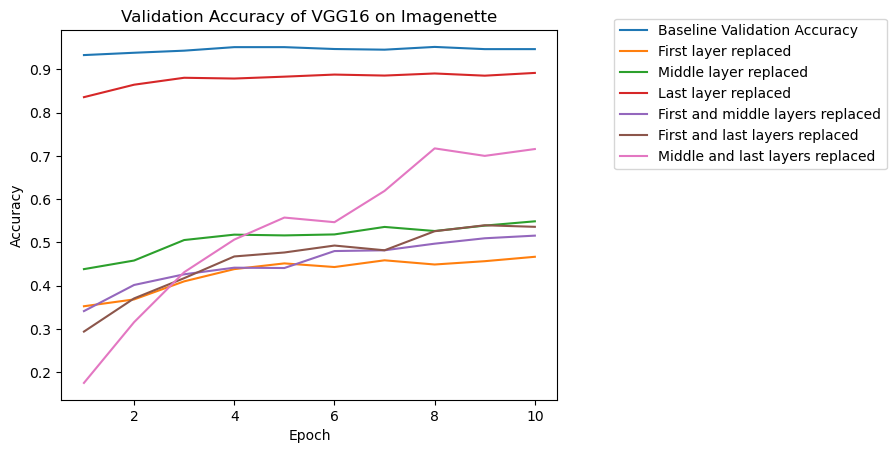

[0.93324841 0.93859873 0.94343949 0.95159236 0.95159236 0.94726115
 0.94573248 0.95210191 0.94700637 0.94700637]


In [38]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.plot(epoch, val_accuracy_first, label="First layer replaced")
plt.plot(epoch, val_accuracy_middle, label="Middle layer replaced")
plt.plot(epoch, val_accuracy_last, label="Last layer replaced")
plt.plot(epoch, val_accuracy_first_middle, label="First and middle layers replaced")
plt.plot(epoch, val_accuracy_first_last, label="First and last layers replaced")
plt.plot(epoch, val_accuracy_middle_last, label="Middle and last layers replaced")
plt.title("Validation Accuracy of VGG16 on Imagenette")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy_changed)
print(val_accuracies)

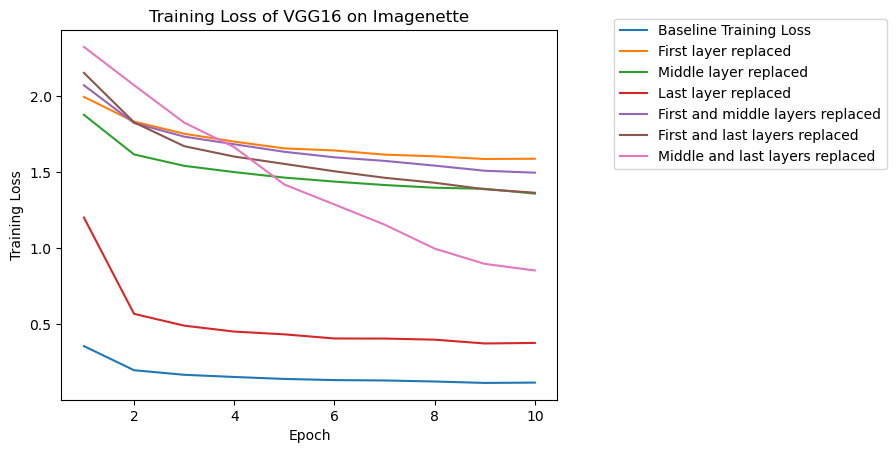

[0.35361032 0.19487601 0.16470473 0.15031777 0.13742669 0.12981974
 0.12740589 0.12054163 0.11116141 0.113311  ]


In [39]:
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.plot(epoch, train_loss_first, label="First layer replaced")
plt.plot(epoch, train_loss_middle, label="Middle layer replaced")
plt.plot(epoch, train_loss_last, label="Last layer replaced")
plt.plot(epoch, train_loss_first_middle, label="First and middle layers replaced")
plt.plot(epoch, train_loss_first_last, label="First and last layers replaced")
plt.plot(epoch, train_loss_middle_last, label="Middle and last layers replaced")
plt.title("Training Loss of VGG16 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

# print(train_loss_changed)
print(train_losses)

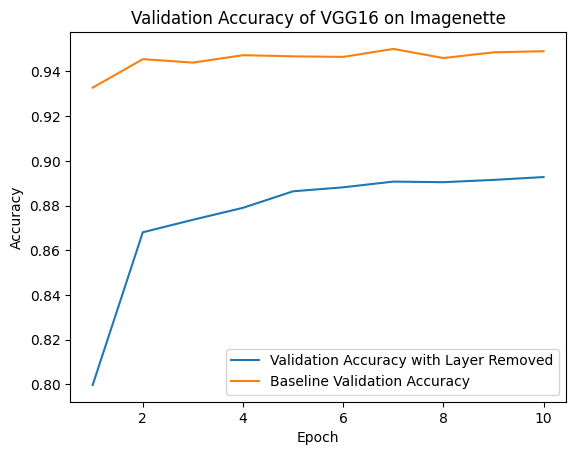

[0.93273885 0.94547771 0.94394904 0.94726115 0.94675159 0.94649682
 0.95006369 0.94598726 0.94853503 0.94904459]


In [25]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy_changed_correct, label="Validation Accuracy with Layer Removed")
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of VGG16 on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy_changed)
print(val_accuracies)

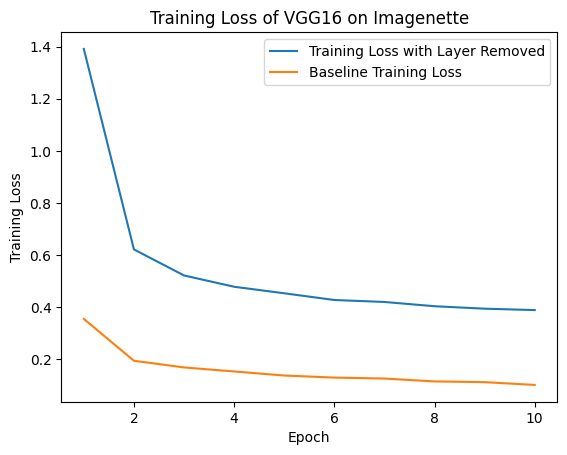

[0.35551925 0.1950045  0.16939413 0.15396993 0.13841327 0.13048469
 0.12684698 0.11576093 0.11293987 0.10235216]


In [26]:
plt.plot(epoch, train_loss_changed_correct, label="Training Loss with Layer Removed")
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.title("Training Loss of VGG16 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# print(train_loss_changed)
print(train_losses)